In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
#remember to change this lol
all_data = pd.read_csv('2025_LoL_esports_match_data_from_OraclesElixir.csv')
all_data[:10]

/var/folders/2h/80xj55qs223gk3hzcqk03zxh0000gn/T/ipykernel_4896/2755685063.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv('2025_LoL_esports_match_data_from_OraclesElixir.csv')


,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,200.0,224.0,-1.0,17.0,1.0,1.0,2.0,2.0,4.0,2.0
1,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,157.0,-2363.0,-1444.0,-18.0,0.0,1.0,2.0,1.0,7.0,0.0
2,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,241.0,-1552.0,-2465.0,-41.0,1.0,0.0,2.0,1.0,5.0,1.0
3,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,257.0,-2613.0,-1156.0,-6.0,1.0,1.0,2.0,6.0,2.0,0.0
4,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,20.0,-662.0,-734.0,18.0,0.0,2.0,2.0,0.0,8.0,0.0
5,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,217.0,-224.0,1.0,-17.0,2.0,4.0,2.0,1.0,1.0,2.0
6,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,139.0,2363.0,1444.0,18.0,1.0,7.0,0.0,0.0,1.0,2.0
7,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,200.0,1552.0,2465.0,41.0,1.0,5.0,1.0,1.0,0.0,2.0
8,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,251.0,2613.0,1156.0,6.0,6.0,2.0,0.0,1.0,1.0,2.0
9,LOLTMNT03_179647,complete,NaN,LFL2,2025,Winter,0,2025-01-11 11:11:24,1,15.01,...,38.0,662.0,734.0,-18.0,0.0,8.0,0.0,0.0,2.0,2.0


In [6]:
all_data['league'].unique()

array(['LFL2', 'LPL', 'LCKC', 'LVP SL', 'LCK', 'NLC', 'LCP', 'LEC', 'HLL',
       'PRM', 'LFL', 'LIT', 'TCL', 'HW', 'LJL', 'LTA S', 'LTA N', 'RL',
       'NEXO', 'CD', 'EBL', 'PCS', 'ROL', 'LPLOL', 'AL', 'LTA', 'VCS',
       'FST', 'EM', 'LRS', 'LRN', 'NACL', 'LAS', 'HC', 'PRMP', 'HM', 'CT',
       'Asia Master', 'MSI', 'EWC', 'WLDs', 'ASI', 'IC'], dtype=object)

In [7]:
#number of players in the major leagues
len(all_data[[True if l in ['LTA','LPL','LCK','LEC','LTA S', 'LTA N'] else False for l in all_data['league']]]['playername'].unique())

372

In [8]:
#number of games from major leagues 
len(all_data[[True if l in ['LTA','LPL','LCK','LEC','LTA S', 'LTA N'] else False for l in all_data['league']]]['gameid'].unique())

2141

# Filter data to only consider major leagues
The major leagues are LPL, LCK, LEC, LCP, LTA
(LTA is splitted to LTA N and LTA S, but we will consider them to be the same

In [38]:
major_league_data = all_data[all_data['league'].isin(['LTA','LPL','LCK','LEC','LTA S','LTA N', 'LCP'])]

major_league_data = major_league_data.copy()

#filter out 'team' role
major_league_data = major_league_data[major_league_data['position'] != 'team']


#making LTA just LTA
major_league_data['league'] = major_league_data['league'].replace({'LTA S': 'LTA', 'LTA N': 'LTA'})


major_league_data[:10]

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
48,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
len(major_league_data['champion'][major_league_data['position'] != 'team'].unique())

157

In [11]:
major_league_data['position'][major_league_data['position'] != 'team'].unique()

array(['top', 'jng', 'mid', 'bot', 'sup'], dtype=object)

In [12]:
for p in major_league_data['position'][major_league_data['position'] != 'team'].unique():
    print(p,len(major_league_data[major_league_data['position'] == p]['champion'].unique()))

top 67
jng 47
mid 62
bot 34
sup 46


In [13]:
group_by_player = major_league_data[major_league_data['position'] != 'team'].groupby('playername').count().reset_index()
len(group_by_player['playername'][group_by_player['position'] >= 5].unique())

419

In [14]:
group_by_player['playername'][group_by_player['position'] >= 100].unique()

array(['369', 'Aiming', 'Bdd', 'Beichuan', 'BeryL', 'Bin', 'Breathe',
       'Canyon', 'Care', 'Chovy', 'Clozer', 'Creme', 'Crisp', 'Cube',
       'Cuzz', 'Delight', 'Diable', 'Doinb', 'Doran', 'Duro', 'Elk',
       'Faker', 'Flandre', 'GALA', 'GIDEON', 'Hope', 'JackeyLove',
       'Jiejie', 'Jiwoo', 'Jwei', 'Kael', 'Kanavi', 'Karis', 'Kellin',
       'Keria', 'Kiin', 'Kingen', 'Knight', 'Leave', 'Lehends', 'Light',
       'Lucid', 'Meiko', 'Monki', 'Morgan', 'ON', 'Oner', 'Peanut',
       'Peyz', 'Pollu', 'Raptor', 'Rookie', 'Ruler', 'Scout', 'Shad0w',
       'Shanks', 'ShowMaker', 'Siwoo', 'Taeyoon', 'Tarzan', 'TheShy',
       'Tian', 'Vampire', 'Viper', 'Xiaohu', 'Xun', 'Zeka', 'Zeus',
       'deokdam', 'sheer'], dtype=object)

In [15]:
group_by_player['position'].mean()

53.80530973451327

In [16]:
group_by_player

,playername,gameid,datacompleteness,url,league,year,split,playoffs,date,game,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
0,113,38,38,0,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
1,1Jiang,70,70,70,70,70,70,70,70,70,...,0,0,0,0,0,0,0,0,0,0
2,1jw,7,7,0,7,7,0,7,7,7,...,6,6,6,6,6,6,6,6,6,6
3,1xn,98,98,98,98,98,98,98,98,98,...,0,0,0,0,0,0,0,0,0,0
4,369,152,152,152,152,152,152,152,152,152,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,vital,4,4,0,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
448,xiaofang,29,29,29,29,29,29,29,29,29,...,0,0,0,0,0,0,0,0,0,0
449,xiaohuangren,24,24,24,24,24,24,24,24,24,...,0,0,0,0,0,0,0,0,0,0
450,xqw,62,62,62,62,62,62,62,62,62,...,0,0,0,0,0,0,0,0,0,0


# Brainstorm


## predict region
    from player performance
        data: player seasonal average
            each player will get a row

    from end of game data *****
        data: games
            each game will get a row



## predict player name
    from player stats

    for players that played more than n number of games



## predict position
    from player stats



# Predict player league 

### data origin
https://oracleselixir.com/tools/downloads
https://oracleselixir.com/definitions

https://drive.google.com/drive/u/0/folders/1gLSw0RLjBbtaNy0dgnGQDAZOHIgCe-HH

In [17]:
major_league_data[:2]

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat25,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25
48,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,11715-11715_game_1,partial,https://lpl.qq.com/es/stats.shtml?bmid=11715,LPL,2025,Split 1,0,2025-01-12 09:24:17,1,15.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# we might need to combine LTA S, LTA N and LTA to just LTA
leagues = ['LPL', 'LCK', 'LEC', 'LTA', 'LCP']

In [19]:
major_league_data['league'].unique()

array(['LPL', 'LCK', 'LCP', 'LEC', 'LTA'], dtype=object)

In [20]:
### potential columns
y_cols = 'league'

X_cols = ['position', 'champion', 'kills', 'deaths', 'assists', 'team kpm', 'ckpm', 
    'damagetochampions', 'dpm', 'damageshare', 'damagetakenperminute',
    'wardsplaced', 'wpm', 'wardskilled', 'wcpm', 'controlwardsbought','earnedgold',
    'earned gpm', 'earnedgoldshare', 'total cs', 'minionkills', 'monsterkills',
    'monsterkillsownjungle', #alot of  nulls
    'monsterkillsenemyjungle', 
     'goldat15', 'xpat15', 'csat15','golddiffat15', 'xpdiffat15', 'csdiffat15',
    'killsat15', 'assistsat15', 'deathsat15', 'goldat25', 'xpat25', 'csat25','golddiffat25', 'xpdiffat25', 'csdiffat25',
    'killsat25', 'assistsat25', 'deathsat25']

In [79]:
major_league_data_df = major_league_data[X_cols + [y_cols]]

## Charts

In [51]:
# Step 1: 找每個 league 的 top 10 champions
top10_each = (
    major_league_data
        .groupby("league")["champion"]
        .value_counts()
        .groupby(level=0)
        .head(10)
        .reset_index(name="count")
)

# Step 2: 為每個 league 建立 rank（1-10）
top10_each["rank"] = top10_each.groupby("league")["count"].rank(
    method="first", ascending=False
).astype(int)

# Step 3: pivot table → rank 為 index，value 是 champion 名字
rank_table = top10_each.pivot(
    index="rank", columns="league", values="champion"
).sort_index()

rank_table


league,LCK,LCP,LEC,LPL,LTA
rank,,,,,
1,Xin Zhao,Corki,Rell,Xin Zhao,Xin Zhao
2,Rumble,Xin Zhao,Corki,Alistar,Alistar
3,Ambessa,Alistar,Ezreal,Rell,Rell
4,Alistar,Ambessa,Varus,Taliyah,Rakan
5,Wukong,Rakan,Rakan,Rumble,Rumble
6,Rell,Rumble,Xin Zhao,Ambessa,Ezreal
7,Taliyah,Rell,Alistar,Varus,Corki
8,Azir,Varus,Sejuani,Nautilus,Sejuani
9,Rakan,Kai'Sa,Taliyah,Kai'Sa,Vi


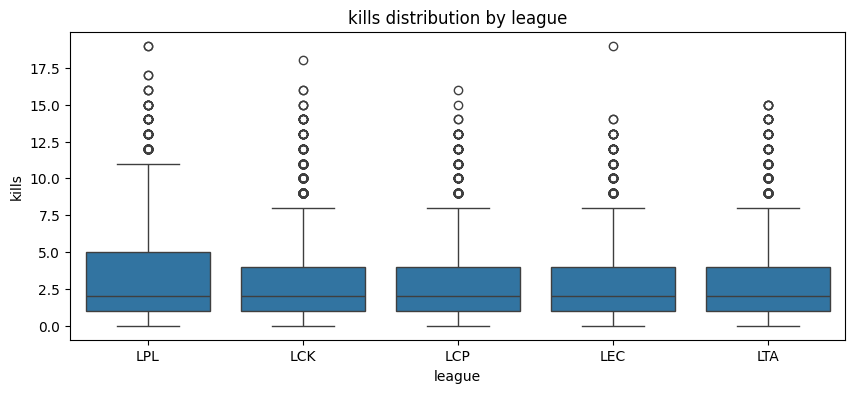

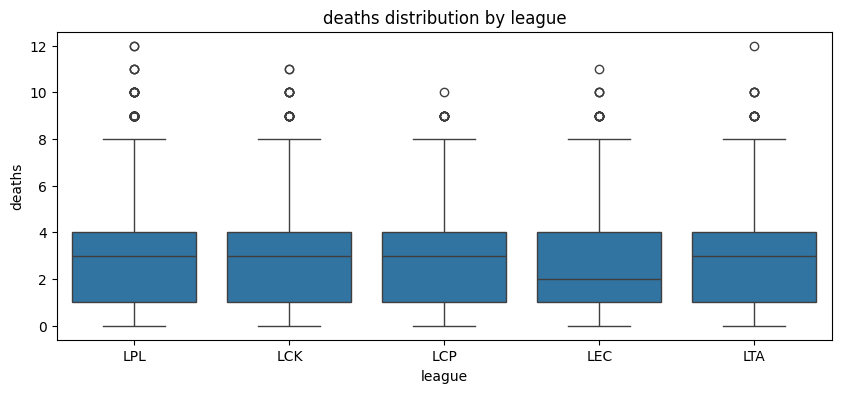

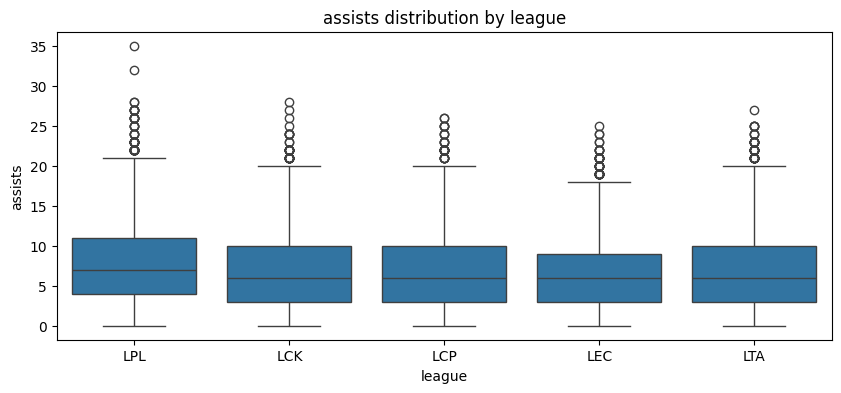

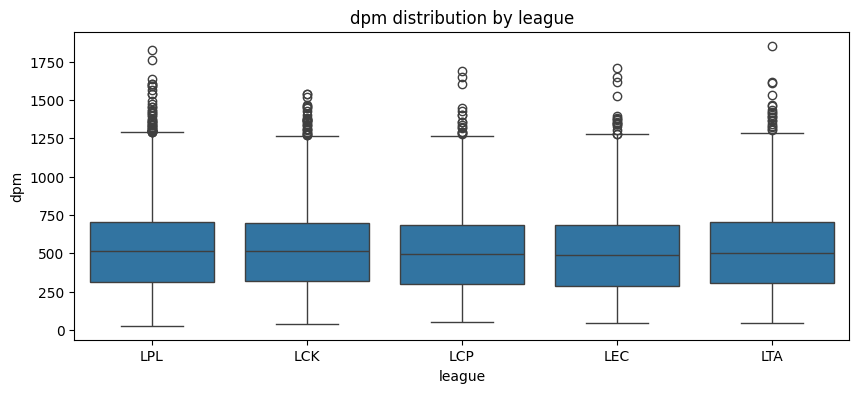

In [35]:
combat_cols = ['kills', 'deaths', 'assists', 'dpm']

for col in combat_cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=major_league_data, x='league', y=col)
    plt.title(f'{col} distribution by league')
    plt.show()


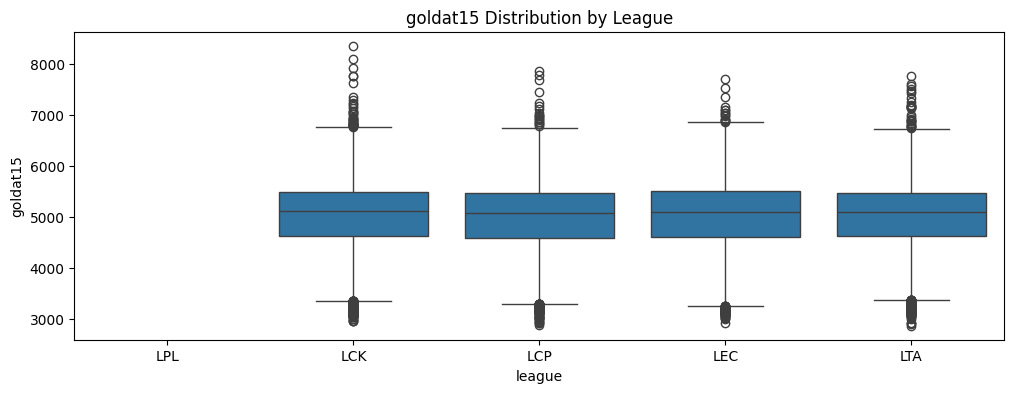

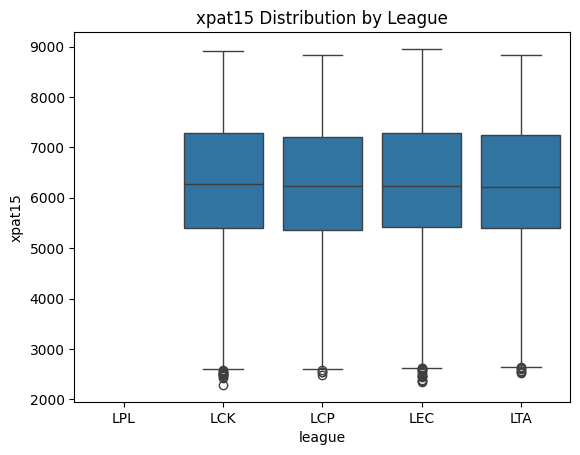

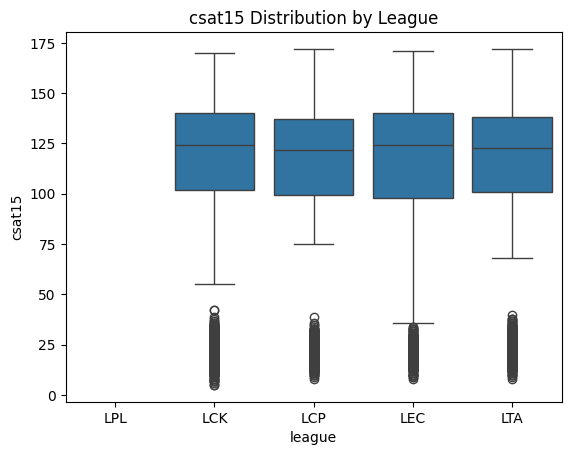

In [36]:
cols = ['goldat15', 'xpat15', 'csat15']

plt.figure(figsize=(12,4))
for c in cols:
    sns.boxplot(data=major_league_data, x='league', y=c)
    plt.title(f'{c} Distribution by League')
    plt.show()


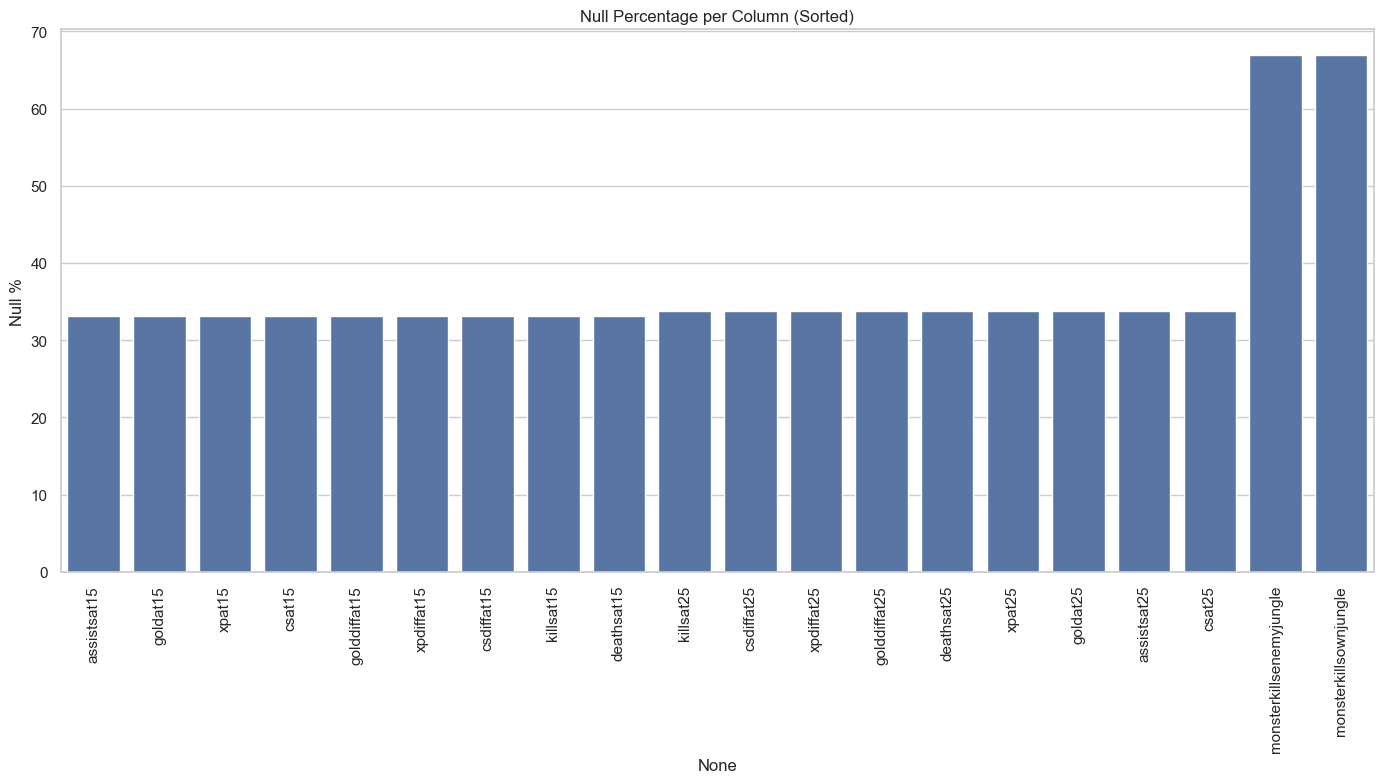

In [92]:
#Plot each column’s NULL % (overall)
threshold = 0  # 顯示 null > 20% 的欄位
null_percent = major_league_data_df.isnull().mean() * 100
filtered_null = null_percent[null_percent > threshold]
sorted_null = filtered_null.sort_values()

plt.figure(figsize=(14,8))
sns.barplot(y=sorted_null.values, x=sorted_null.index)
plt.xticks(rotation=90)
plt.ylabel("Null %")
plt.title("Null Percentage per Column (Sorted)")
plt.tight_layout()
plt.show()


/var/folders/2h/80xj55qs223gk3hzcqk03zxh0000gn/T/ipykernel_4896/3448054600.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.isnull().mean() * 100)


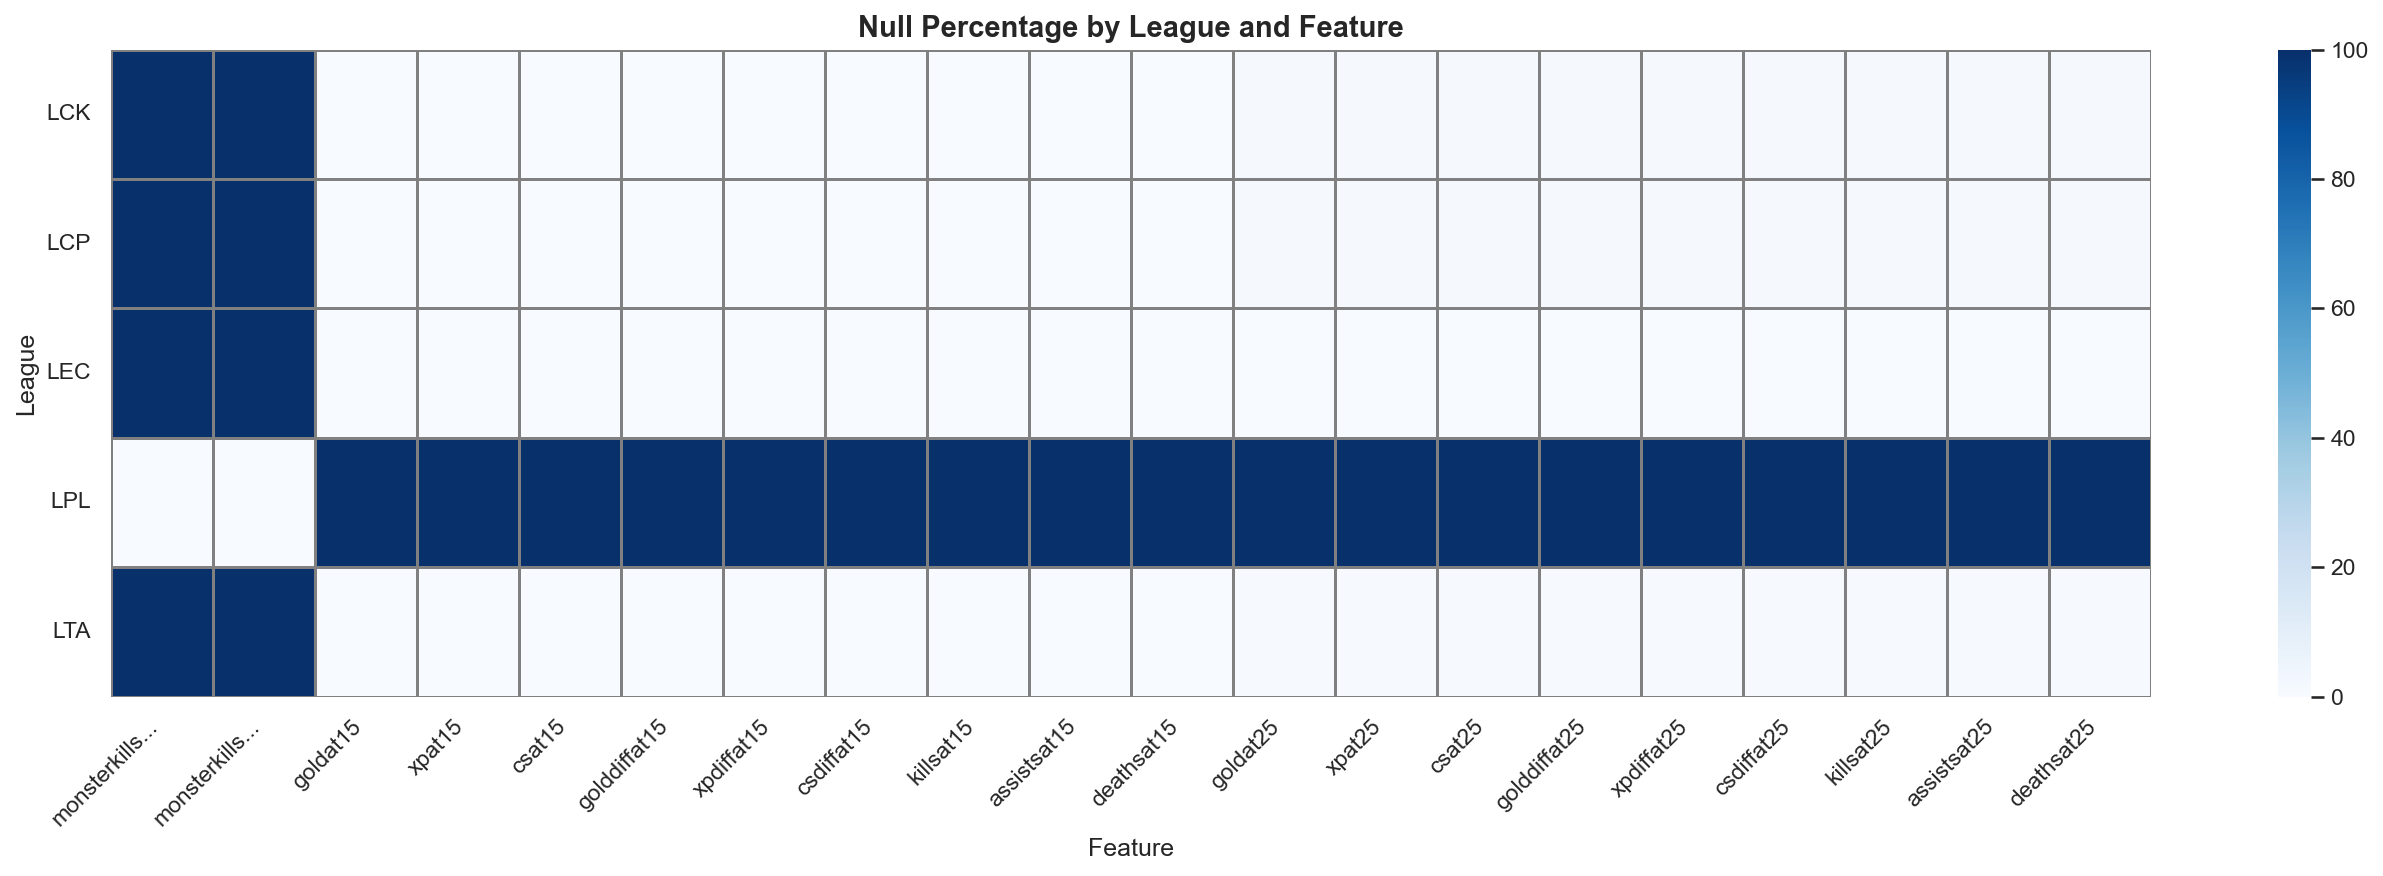

In [91]:
# 2. Null % by league (feature × league heatmap)
null_by_league = (
    major_league_data_df
        .groupby("league")
        .apply(lambda df: df.isnull().mean() * 100)
)

# ====== Step 2. Filter columns with meaningful nulls (> 5%) ======
filtered_null = null_by_league.loc[:, null_by_league.max() > 5]

# ====== Step 3. Optional: shorten long names for readability ======
short_cols = [c[:12] + "..." if len(c) > 12 else c for c in filtered_null.columns]
filtered_null.columns = short_cols

# ====== Step 4. Plot Beautiful Heatmap ======
plt.figure(figsize=(18, 6), dpi=150)

sns.heatmap(
    filtered_null,
    cmap="Blues",
    linewidths=.5,     
    linecolor="gray"
)

plt.title("Null Percentage by League and Feature", fontsize=14, fontweight="bold")
plt.xlabel("Feature", fontsize=12)
plt.ylabel("League", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

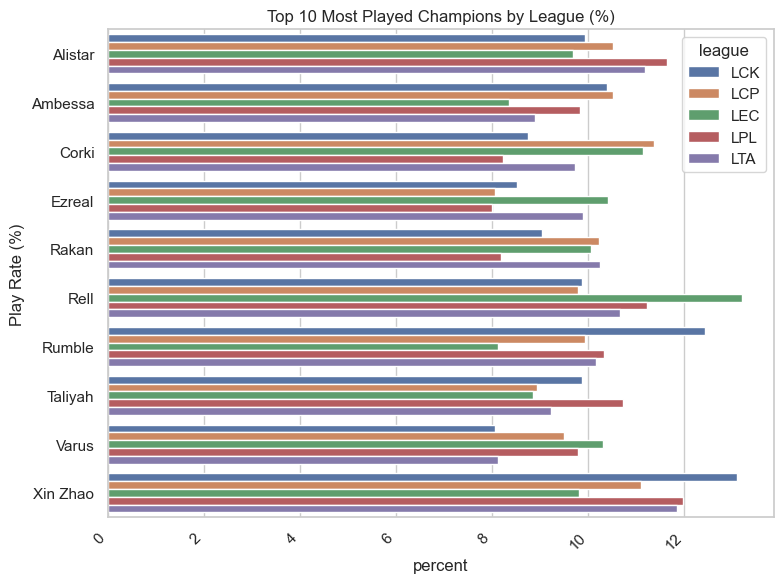

In [94]:
top10_champions = (
    major_league_data['champion']
        .value_counts()
        .head(10)
        .index
)

filtered = major_league_data[major_league_data['champion'].isin(top10_champions)]
games_per_league = filtered.groupby('league').size()

percent_df = (
    filtered
        .groupby(['league', 'champion'])
        .size()
        .div(games_per_league, level='league')
        .mul(100)
        .reset_index(name='percent')
)

plt.figure(figsize=(8,6))
sns.barplot(
    data=percent_df,
    x='percent',
    y='champion',
    hue='league',
    orient='h'
)

plt.title('Top 10 Most Played Champions by League (%)')
plt.ylabel('Champion')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


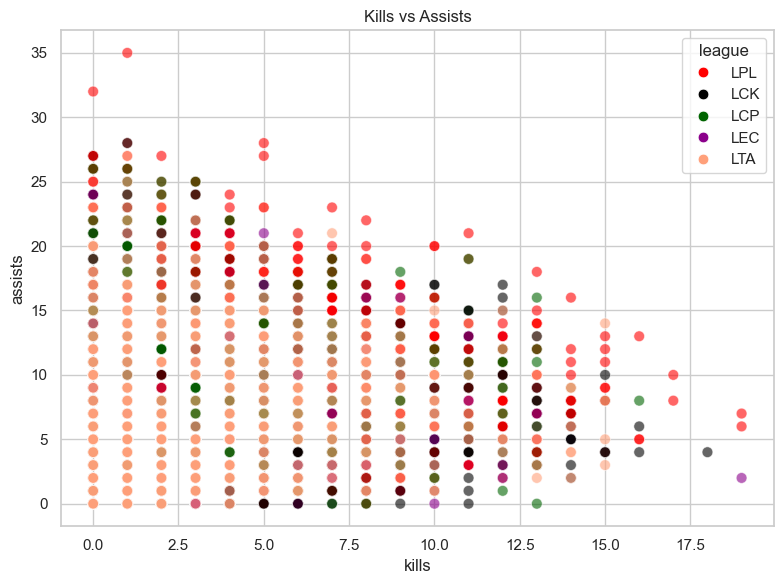

In [75]:
# sns.set(style="whitegrid")  # 好看背景

league_colors = {
    "LPL": "#FF0000",   # red
    "LCK": "#000000",   # black
    "LCP": "#006400",   # green
    "LEC": "#8B008B",   # purple
    "LTA": "#FFA07A",   # orange
}

# --- Scatter 1: kills vs assists ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=major_league_data,
    x='kills',
    y='assists',
    hue='league',
    palette=league_colors,
    alpha=0.6,
    s=60
)
handles, labels = plt.gca().get_legend_handles_labels()
new_handles = []
for h, label in zip(handles, labels):
    if label in league_colors:
        h.set_color(league_colors[label])   # overwrite color
        h.set_alpha(1.0)
    new_handles.append(h)

plt.legend(new_handles, labels, title="league")

plt.title("Kills vs Assists")
plt.tight_layout()
plt.show()


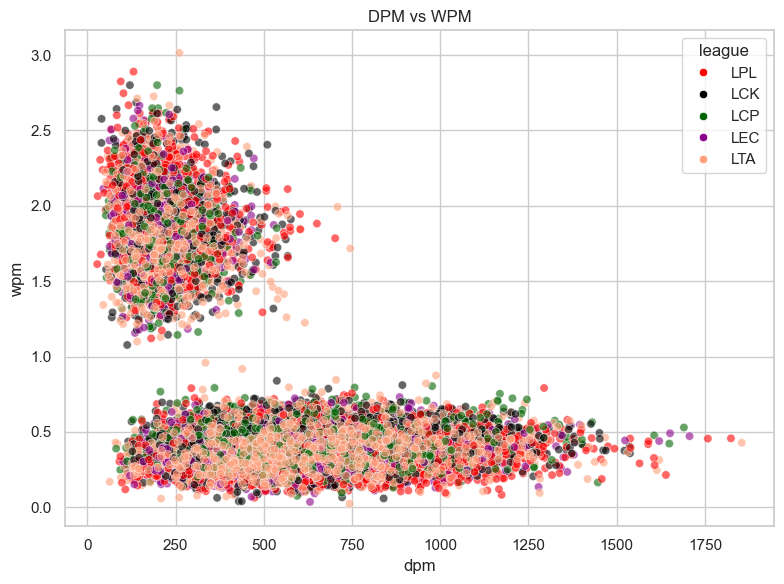

In [72]:
# --- Scatter 2: dpm vs wpm ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=major_league_data,
    x='dpm',
    y='wpm',
    hue='league',
    palette=league_colors,
    alpha=0.6
)

handles, labels = plt.gca().get_legend_handles_labels()
new_handles = []
for h, label in zip(handles, labels):
    if label in league_colors:
        h.set_color(league_colors[label])   # overwrite color
        h.set_alpha(1.0)
    new_handles.append(h)

plt.legend(new_handles, labels, title="league")

plt.title("DPM vs WPM")
plt.tight_layout()
plt.show()

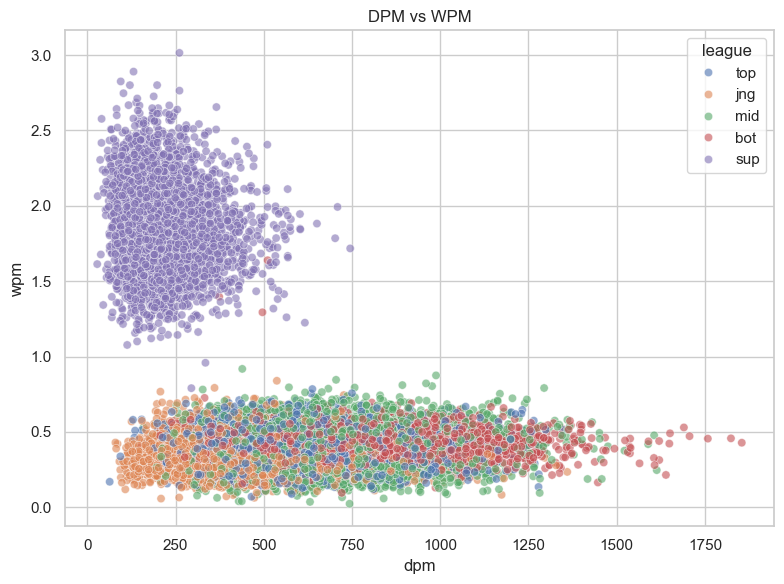

In [78]:
# --- Scatter 2: dpm vs wpm ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=major_league_data,
    x='dpm',
    y='wpm',
    hue='position',
    alpha=0.6
)

handles, labels = plt.gca().get_legend_handles_labels()
new_handles = []
for h, label in zip(handles, labels):
    if label in league_colors:
        h.set_color(league_colors[label])   # overwrite color
        h.set_alpha(1.0)
    new_handles.append(h)

plt.legend(new_handles, labels, title="Position")

plt.title("DPM vs WPM")
plt.tight_layout()
plt.show()

In [18]:
major_league_data['position'].unique()

array(['top', 'jng', 'mid', 'bot', 'sup'], dtype=object)

In [19]:
#### This is renamed


In [20]:
major_league_data_df.shape

(24320, 43)

In [21]:
major_league_data_df.isnull().mean()  #alot of nulls we cant use in the original

position                   0.000000
champion                   0.000000
kills                      0.000000
deaths                     0.000000
assists                    0.000000
team kpm                   0.000000
ckpm                       0.000000
damagetochampions          0.000000
dpm                        0.000000
damageshare                0.000000
damagetakenperminute       0.000000
wardsplaced                0.000000
wpm                        0.000000
wardskilled                0.000000
wcpm                       0.000000
controlwardsbought         0.000000
earnedgold                 0.000000
earned gpm                 0.000000
earnedgoldshare            0.000000
total cs                   0.000000
minionkills                0.000000
monsterkills               0.000000
monsterkillsownjungle      0.668997
monsterkillsenemyjungle    0.668997
goldat15                   0.331003
xpat15                     0.331003
csat15                     0.331003
golddiffat15               0

In [22]:
cols_with_nulls = ['monsterkillsownjungle', 
    'monsterkillsenemyjungle',
    'goldat15', 'xpat15', 'csat15','golddiffat15', 'xpdiffat15', 'csdiffat15',
    'killsat15', 'assistsat15', 'deathsat15', 'goldat25', 'xpat25', 'csat25',
    'golddiffat25', 'xpdiffat25', 'csdiffat25', 'killsat25', 'assistsat25', 'deathsat25'
]

# Make sure we are working on a proper copy
major_league_data_df = major_league_data_df.copy()

for col in cols_with_nulls:
    # Compute league mean
    league_means = major_league_data_df.groupby('league')[col].transform('mean')
    
    # Fill nulls with league mean first
    major_league_data_df.loc[:, col] = major_league_data_df[col].fillna(league_means)
    
    # Fill any remaining nulls (if league mean was NaN) with global mean
    global_mean = major_league_data_df[col].mean()
    major_league_data_df.loc[:, col] = major_league_data_df[col].fillna(global_mean)

In [23]:
# dropping null rows
#major_league_data_df = major_league_data_df.dropna()
major_league_data_df.shape

(24320, 43)

In [24]:
major_league_data_df['league'].unique()

array(['LPL', 'LCK', 'LCP', 'LEC', 'LTA'], dtype=object)

In [25]:
#create train and test set
train_df, test_df = train_test_split(
    major_league_data_df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=major_league_data_df['league']
)


### Random Baseline

In [26]:
leagues = ['LPL', 'LCK', 'LEC', 'LTA', 'LCP']

y_pred_random = np.random.choice(leagues, size=len(test_df))
y_true = test_df['league']
baseline_accuracy = accuracy_score(y_true, y_pred_random)

print("Random baseline accuracy:", baseline_accuracy)

Random baseline accuracy: 0.20333059210526316


### KNN Baseline

In [27]:
X_train_knn = train_df[X_cols]
y_train_knn = train_df[y_cols]

X_test_knn = test_df[X_cols]
y_test_knn = test_df[y_cols]

In [28]:
categorical_cols = ['position', 'champion']
numeric_cols = [col for col in X_cols if col not in categorical_cols]

preprocess_knn = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

knn_model = Pipeline(steps=[
    ("preprocess", preprocess_knn),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

knn_model.fit(X_train_knn, y_train_knn)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['position', 'champion']),
                                                 ('num', StandardScaler(),
                                                  ['kills', 'deaths', 'assists',
                                                   'team kpm', 'ckpm',
                                                   'damagetochampions', 'dpm',
                                                   'damageshare',
                                                   'damagetakenperminute',
                                                   'wardsplaced', 'wpm',
                                                   'wardskilled', 'wcpm',
                                                   'controlwardsbought',
                                                   'earnedgold', 'earned gpm',
                                                   'earnedgoldshare',
                                                   'total cs', 'minionkills',
                                                   'monsterkills',
                                                   'monsterkillsownjungle',
                                                   'monsterkillsenemyjungle',
                                                   'goldat15', 'xpat15',
                                                   'csat15', 'golddiffat15',
                                                   'xpdiffat15', 'csdiffat15',
                                                   'killsat15', 'assistsat15', ...])])),
                ('knn', KNeighborsClassifier())])

In [29]:
y_pred_knn = knn_model.predict(X_test_knn)

print("KNN Test Accuracy:", accuracy_score(y_test_knn, y_pred_knn))
print(classification_report(y_test_knn, y_pred_knn))

KNN Test Accuracy: 0.5302220394736842
              precision    recall  f1-score   support

         LCK       0.35      0.52      0.42      1110
         LCP       0.18      0.13      0.15       582
         LEC       0.21      0.16      0.18       612
         LPL       0.96      1.00      0.98      1610
         LTA       0.33      0.23      0.27       950

    accuracy                           0.53      4864
   macro avg       0.41      0.41      0.40      4864
weighted avg       0.51      0.53      0.51      4864



### non position split logistic regression baseline

In [30]:
X_train_logreg = train_df[X_cols]
y_train_logreg = train_df[y_cols]

X_test_logreg = test_df[X_cols]
y_test_logreg = test_df[y_cols]

In [31]:
categorical_cols = ['position', 'champion']
numeric_cols = [col for col in X_cols if col not in categorical_cols]

preprocess_logreg = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

logreg_model = Pipeline(steps=[
    ("preprocess", preprocess_logreg),
    ("logreg", LogisticRegression(max_iter=2000, multi_class="multinomial"))
])

logreg_model.fit(X_train_logreg, y_train_logreg)

C:\Users\jayde\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['position', 'champion']),
                                                 ('num', StandardScaler(),
                                                  ['kills', 'deaths', 'assists',
                                                   'team kpm', 'ckpm',
                                                   'damagetochampions', 'dpm',
                                                   'damageshare',
                                                   'damagetakenperminute',
                                                   'wardsplaced', 'wpm',
                                                   'wardskilled', 'wcpm',
                                                   'controlwardsbought',
                                                   'earnedgold', 'earned gpm',
                                                   'earnedgoldshare',
                                                   'total cs', 'minionkills',
                                                   'monsterkills',
                                                   'monsterkillsownjungle',
                                                   'monsterkillsenemyjungle',
                                                   'goldat15', 'xpat15',
                                                   'csat15', 'golddiffat15',
                                                   'xpdiffat15', 'csdiffat15',
                                                   'killsat15', 'assistsat15', ...])])),
                ('logreg',
                 LogisticRegression(max_iter=2000, multi_class='multinomial'))])

In [32]:
y_pred_logreg = logreg_model.predict(X_test_logreg)

print("Logistic Regression Test Accuracy:", accuracy_score(y_test_logreg, y_pred_logreg))
print(classification_report(y_test_logreg, y_pred_logreg))

Logistic Regression Test Accuracy: 0.34745065789473684
              precision    recall  f1-score   support

         LCK       0.31      0.23      0.26      1110
         LCP       0.25      0.02      0.04       582
         LEC       0.31      0.13      0.18       612
         LPL       0.38      0.73      0.50      1610
         LTA       0.27      0.18      0.21       950

    accuracy                           0.35      4864
   macro avg       0.30      0.26      0.24      4864
weighted avg       0.32      0.35      0.29      4864



### split by position logistic regression

In [33]:
#split and store into a dictionary that has position as keys
positions = ['top', 'jng', 'mid', 'bot', 'sup']

train_by_position = {
    pos: train_df[train_df['position'] == pos].copy()
    for pos in positions
}

test_by_position = {
    pos: test_df[test_df['position'] == pos].copy()
    for pos in positions
}

for pos in positions:
    print(pos, len(train_by_position[pos]), len(test_by_position[pos]))

top 3905 959
jng 3871 993
mid 3911 953
bot 3898 966
sup 3871 993


In [34]:
categorical_cols = ['champion']  # "position" is constant in each subset, so drop it
numeric_cols = [col for col in X_cols if col not in categorical_cols + ['position']]

models_by_position = {}

for pos in positions:
    
    train_pos = train_by_position[pos]
    
    X_train = train_pos[X_cols]
    y_train = train_pos[y_cols]

    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ("num", StandardScaler(), numeric_cols)
        ]
    )

    model = Pipeline(steps=[
        ("preprocess", preprocess),
        ("logreg", LogisticRegression(max_iter=2000, multi_class="multinomial"))
    ])

    model.fit(X_train, y_train)
    models_by_position[pos] = model

C:\Users\jayde\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jayde\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jayde\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\jayde\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

In [35]:
# the function
def predict_position_model(row, models_dict):
    """
    row: dictionary or pandas Series containing at least 'position' + feature columns
    models_dict: dict mapping positions → trained logistic regression models
    """
    
    # If user passes a dict, convert to DataFrame (single row)
    if isinstance(row, dict):
        row_df = pd.DataFrame([row])
    else:
        row_df = row.to_frame().T   # if it's a pandas Series
    
    pos = row_df['position'].iloc[0]
    
    if pos not in models_dict:
        raise ValueError(f"Unknown position '{pos}', must be one of: {list(models_dict.keys())}")
    
    model = models_dict[pos]
    
    # Predict
    prediction = model.predict(row_df[X_cols])[0]
    
    return prediction

In [36]:
test_predictions = []

for idx, row in test_df.iterrows():
    pred = predict_position_model(row, models_by_position)
    test_predictions.append(pred)

In [37]:
y_test_logreg_split = test_df[y_cols]

In [38]:
accuracy = accuracy_score(y_test_logreg_split, test_predictions)
print("Overall test accuracy across all positions:", accuracy)

Overall test accuracy across all positions: 0.6155427631578947


In [39]:
print(classification_report(y_test_logreg_split, test_predictions))

              precision    recall  f1-score   support

         LCK       0.45      0.61      0.52      1110
         LCP       0.35      0.16      0.22       582
         LEC       0.41      0.28      0.33       612
         LPL       0.98      0.99      0.98      1610
         LTA       0.44      0.49      0.47       950

    accuracy                           0.62      4864
   macro avg       0.53      0.50      0.50      4864
weighted avg       0.61      0.62      0.60      4864



In [40]:
test_df['league'].unique()

array(['LPL', 'LCP', 'LCK', 'LTA', 'LEC'], dtype=object)

In [41]:
positions = ['top', 'jng', 'mid', 'bot', 'sup']

# test_predictions should be in the same order as test_df
for pos in positions:
    # boolean mask
    mask = test_df['position'] == pos
    
    # get the row numbers (0-based) corresponding to True in the mask
    row_indices = mask[mask].index  # original df indices, we need positions in list
    # safer: use numpy to get integer positions
    row_positions = mask.to_numpy().nonzero()[0]  # these are 0-based positions
    
    # true and predicted values
    y_true_pos = y_test_logreg_split.iloc[row_positions]
    y_pred_pos = [test_predictions[i] for i in row_positions]
    
    acc = accuracy_score(y_true_pos, y_pred_pos)
    print(f"{pos} accuracy: {acc:.3f}")

top accuracy: 0.623
jng accuracy: 0.624
mid accuracy: 0.608
bot accuracy: 0.608
sup accuracy: 0.615
